In [2]:
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
from ast import literal_eval
from html.parser import HTMLParser
import pickle
from nltk import sent_tokenize, word_tokenize
import random
from collections import Counter
import matplotlib.pyplot as plt

tqdm().pandas()

In this notebook, I collected the data from the Acrolinx blog posts, funnelled it into a shape usable with the Doccano annotation tool, and after that tool was used re-collected the annotated data and ran some tests and statistics on it.

# Access Data

The blog posts were provided in one large XML file. I parsed this file and separated out the posts, with the relevant metadata, into a pandas DataFrame.

In [84]:
acrofile = 'data/acrolinx.WordPress.2019-05-21.xml'

In [85]:
tree = ET.parse(acrofile)
root = tree.getroot()
channel = tree.find('channel')

In [86]:
titles = []
dates = []
categories = []
texts = []

for item in channel:
    if item.tag == 'item':
        titles.append(item.find('title').text)
        dates.append(item.find('pubDate').text)
        
        texts.append(item.find('{http://purl.org/rss/1.0/modules/content/}encoded').text)
        
        cats = []
        for child in item:
            if child.tag == 'category':
                cats.append(child.text)
        categories.append(list(set(cats)))

In [87]:
assert len(titles) == len(dates) == len(categories) == len(texts)

In [88]:
df = pd.DataFrame({'title': titles, 
                  'pubdate': dates,
                  'cats': categories,
                  'text': texts})

In [89]:
df.head()

,cats,pubdate,text,title
0,"[Content Marketing, Tech Comm, Blog]","Thu, 20 Nov 2014 12:49:29 +0000",Imagine that you’ve just written what you beli...,10 Questions You’ve Got to Ask Yourself Before...
1,"[Content Marketing, Tech Comm, Love of Languag...","Mon, 17 Nov 2014 12:51:04 +0000","We recently shared <a href=""https://www.acroli...",Problem Words that Give Writers Trouble (Part 2)
2,"[Content Marketing, Tech Comm, Love of Languag...","Thu, 13 Nov 2014 12:52:27 +0000",Even the best writers can get tripped up somet...,Problem Words that Give Writers Trouble (Part 1)
3,"[Content Marketing, Tech Comm, Love of Languag...","Mon, 10 Nov 2014 12:55:17 +0000",Part of being a good content marketer is being...,6 Great Free (or Nearly Free) Tools for Conten...
4,"[Content Marketing, Tech Comm, Love of Languag...","Fri, 07 Nov 2014 12:57:14 +0000",Have you ever heard of Amy Cuddy? In addition ...,Why Writers Should Care About Their Posture


# Pre-processing

The data was cleaned before splitting into sentences: HTML tags were removed and other minor issues were cleared.

In [90]:
# remove HTML tags
# https://stackoverflow.com/questions/753052/strip-html-from-strings-in-python

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

df['text'] = df['text'].apply(strip_tags)

,cats,pubdate,text,title
0,"[Content Marketing, Tech Comm, Blog]","Thu, 20 Nov 2014 12:49:29 +0000",Imagine that you’ve just written what you beli...,10 Questions You’ve Got to Ask Yourself Before...
1,"[Content Marketing, Tech Comm, Love of Languag...","Mon, 17 Nov 2014 12:51:04 +0000",We recently shared a post containing part 1 of...,Problem Words that Give Writers Trouble (Part 2)
2,"[Content Marketing, Tech Comm, Love of Languag...","Thu, 13 Nov 2014 12:52:27 +0000",Even the best writers can get tripped up somet...,Problem Words that Give Writers Trouble (Part 1)
3,"[Content Marketing, Tech Comm, Love of Languag...","Mon, 10 Nov 2014 12:55:17 +0000",Part of being a good content marketer is being...,6 Great Free (or Nearly Free) Tools for Conten...
4,"[Content Marketing, Tech Comm, Love of Languag...","Fri, 07 Nov 2014 12:57:14 +0000",Have you ever heard of Amy Cuddy? In addition ...,Why Writers Should Care About Their Posture


In [165]:
def clean_text(text):
    text = text.replace('\n', ' ')
    text = text.strip()
    text = text.replace('’', "'")
    text = text.replace('“', '"')
    text = text.replace('”', '"')
    return text

df.text = df.text.apply(clean_text)

In [167]:
df.to_pickle('data/acrolinx_blog.pkl')

## Side question: how many sentences are in the dataset?

In [168]:
sents = []

for text in df.text:
    sents = sents + sent_tokenize(text)

In [169]:
len(sents)

10919

# Prepare for OpenNMT

To do the planned informal to formal translation, the text had to be put in a txt file with each sentence in a new line.

In [171]:
with open('data/OpenNMT files/src-acrolinx.txt', 'w') as f:
    for sent in sents:
        if len(sent) > 5:
            f.write(' '.join(word_tokenize(sent)) + '\n')

# Examine OpenNMT results

First, a brief look at the model's output is desired.

In [2]:
with open('data/OpenNMT files/src-acrolinx.txt', 'r') as f:
    src = f.readlines()

with open('data/OpenNMT files/pred-acrolinx.txt', 'r') as f:
    pred = f.readlines()

In [3]:
src = [x.strip() for x in src]
pred = [x.strip() for x in pred]

In [4]:
assert len(src) == len(pred)

In [5]:
for idx in random.sample(range(len(src)), 10):
    print(src[idx])
    print(pred[idx])
    print()

Not only do you understand what the authors are trying to convey , you also get the sense that MailChimp is n't some big , soulless corporation .
Do you understand what the authors are trying to convey ? You also get the sense of soulless , soulless corporation .

It 's also where technical content faces the biggest challenges as a result of three converging trends : A rapid acceleration in software development cycles , including online launches Online hosting with embedded content , where bite-sized content produced at frequent intervals is replacing massive tome-sized documents produced over the course of many months An aspiration for localized content in multiple languages timed with product releases Let 's consider these trends , and their implications for technical content , individually .
In multiple languages , it 's technical content faces , the biggest challenges faces , a result of three months is content produced in software releases so I can understand technical content .



# Prepare for Doccano

Next we want to use Doccano to manually select the spans of the sentences which are properly translated and remain within their fragments. We must save the data in CSV format in order to upload it into Doccano.

In [7]:
doccano = pd.DataFrame()

texts = []
for idx in range(len(src)):
    texts.append(src[idx] + ' ' + pred[idx])

In [9]:
doccano['text'] = texts
doccano.head()

,text
0,Imagine that you 've just written what you bel...
1,You 're ready to get it off your plate and sen...
2,"But wait just a second ! But , wait , a second !"
3,"Before you hit the publish button , are you po..."
4,"After all , you 've probably worked hard to cr..."


In [14]:
doccano.to_csv('data/doccano.csv')

# post-Doccano dataset analysis

In [90]:
with open('data/OpenNMT files/src-acrolinx.txt', 'r') as f:
    src = f.readlines()
src = [x.strip() for x in src]

In [91]:
ann = pd.read_json('data/acrolinxblog_annotated.json', lines=True)

In [92]:
ann['source'] = src

In [93]:
ann.head()

,annotations,id,meta,text,source
0,"[{'label': 1, 'end_offset': 22, 'user': 1, 'st...",2,{},"0,Imagine that you 've just written what you b...",Imagine that you 've just written what you bel...
1,"[{'label': 1, 'end_offset': 9, 'user': 1, 'sta...",3,{},"1,You 're ready to get it off your plate and s...",You 're ready to get it off your plate and sen...
2,[],4,{},"2,""But wait just a second ! But , wait , a sec...",But wait just a second !
3,"[{'label': 1, 'end_offset': 68, 'user': 1, 'st...",5,{},"3,""Before you hit the publish button , are you...","Before you hit the publish button , are you po..."
4,"[{'label': 1, 'end_offset': 22, 'user': 1, 'st...",6,{},"4,""After all , you 've probably worked hard to...","After all , you 've probably worked hard to cr..."


In [94]:
ex_text = ann['text'][0]
ex_start = ann['annotations'][0][0]['start_offset']
ex_end = ann['annotations'][0][0]['end_offset']

ex_text[ex_start:ex_end]

"you 've"

In [95]:
edits = []
tbd = []
num = 0

for idx, row in tqdm(ann.iterrows(), total=len(ann)):
    if row['annotations'] == []:
        edits.append(None)
    else:
        current_edits = []        
        # count number of annotations made
        num += len(row['annotations'])
        
        # split annotations into informal and formal changes
        inform_ann = []
        formal_ann = []
        for note in row['annotations']:
            if note['label'] == 1:
                inform_ann.append(note)
            elif note['label'] == 2:
                formal_ann.append(note)
                
        # set aside some to deal with later
        if len(inform_ann) != len(formal_ann):
            tbd.append((idx, row['annotations']))
            edits.append('None')
            continue
        elif inform_ann[-1]['end_offset'] > formal_ann[0]['start_offset']:
            tbd.append((idx, row['annotations']))
            edits.append('None')
            continue
            
        assert len(inform_ann) == len(formal_ann)
        for x in range(len(inform_ann)): # pairs of edits
            inform = row['text'][inform_ann[x]['start_offset']:inform_ann[x]['end_offset']]
            formal = row['text'][formal_ann[x]['start_offset']:formal_ann[x]['end_offset']]
            current_edits.append((inform.strip(), formal.strip()))
        edits.append(current_edits)
        
ann['edits'] = edits
print(num)
print(tbd)


9813
[(20, [{'label': 2, 'end_offset': 17, 'user': 1, 'start_offset': 4}, {'label': 1, 'end_offset': 161, 'user': 1, 'start_offset': 147}]), (32, [{'label': 2, 'end_offset': 33, 'user': 1, 'start_offset': 3}, {'label': 1, 'end_offset': 86, 'user': 1, 'start_offset': 57}]), (183, [{'label': 1, 'end_offset': 75, 'user': 1, 'start_offset': 57}, {'label': 1, 'end_offset': 200, 'user': 1, 'start_offset': 182}, {'label': 1, 'end_offset': 100, 'user': 1, 'start_offset': 89}, {'label': 2, 'end_offset': 228, 'user': 1, 'start_offset': 215}]), (265, [{'label': 2, 'end_offset': 12, 'user': 1, 'start_offset': 5}, {'label': 1, 'end_offset': 202, 'user': 1, 'start_offset': 197}]), (275, [{'label': 2, 'end_offset': 131, 'user': 1, 'start_offset': 77}, {'label': 1, 'end_offset': 237, 'user': 1, 'start_offset': 202}]), (547, [{'label': 2, 'end_offset': 18, 'user': 1, 'start_offset': 4}, {'label': 1, 'end_offset': 146, 'user': 1, 'start_offset': 128}]), (1511, [{'label': 1, 'end_offset': 17, 'user': 1,

In [112]:
len(ann)

10657

In [113]:
len(ann) - ann['edits'].isna().sum()

3817

In [137]:
# now: make formal base sentence with informal edits listed

new_formal = []
new_orig = []
new_repl = []

for idx, row in tqdm(ann.iterrows(), total=len(ann)):
    if type(row['edits']) == list:
        formal_sent = row['source']
        
        # retroactively create most formal sentence
        for item in row['edits']:
            if item[0] == item[1]:
                continue
            formal_sent = formal_sent.replace(item[0], item[1], 1)
            
        # add formal sentence and reversed edits
        for item in row['edits']:
            if item[0] == item[1]:
                continue
            elif len(item[0]) == 0:
                continue
            elif len(item[1]) == 0:
                continue
            elif item[0] == ' ' or item[1] == ' ':
                continue
            new_formal.append(formal_sent)
            new_orig.append(item[1])
            new_repl.append(item[0])
            
new_df = pd.DataFrame()
new_df['Sentence'] = new_formal
new_df['Original'] = new_orig
new_df['Replacement'] = new_repl

In [138]:
len(new_df)

4848

In [139]:
new_df.sample(50)

,Sentence,Original,Replacement
4215,It is important to remember the guidelines for...,you are,you 're
4822,"In order to calculate ROI , you can use this p...",In order to,To
2467,Only 2.3 percent of manufacturing companies ar...,that is,that 's
3569,"If you are a wordsmith woodpecker , you also u...",you are,you 're
497,It would mean that companies have a big opport...,It would mean,That means
162,How do you do that ?,How do,So how do
3733,It is also transformed the meaning of existing...,It is,It 's
99,"If you are a business writer , then you know t...",If you are a business writer,If you 're a business writer
2572,"It is quick and easy to consume , which is cri...",It is,It 's
763,"They want to know , they have , how many page ...",they have,they 've


In [140]:
new_df.to_pickle('data/acrolinx_blog_annotated_df.pkl')

In [141]:
c = Counter()

for idx, row in tqdm(new_df.iterrows(), total=len(new_df)):
    pair = row['Original'] + ' ' + row['Replacement']
    c[pair] += 1
    
c

Counter({'as well , too': 1,
         "I believe it is It 's": 1,
         'it is probably take': 1,
         'three 3': 1,
         'also , too': 1,
         "then what ca n't": 1,
         "you will also receive you 'll also receive": 1,
         'It is a A': 1,
         'I believe it means Alternate means': 1,
         'Well , my Well , sort of ... My': 1,
         'You should make make': 1,
         "large you are n't": 1,
         'may can': 1,
         "can not ca n't": 42,
         "you will be you 're going to be": 1,
         'Get So get': 2,
         'we we then': 1,
         "what is happening what 's happening": 1,
         "it will it 'll": 3,
         'Here in the United States Here in the US': 1,
         'Before But before': 2,
         "where is where 's": 1,
         'often often just': 2,
         "you are specifically doing you 're actually doing": 1,
         'going to gon na': 1,
         "It does not matter It does n't matter": 1,
         'I feel like Looks like

In [142]:
c.most_common()

[("you are you 're", 396),
 ("it is it 's", 310),
 ("It is It 's", 200),
 ("That is That 's", 156),
 ("do not do n't", 137),
 ("they are they 're", 120),
 ("that is that 's", 93),
 ("we are we 're", 90),
 ("you will you 'll", 87),
 ("is not is n't", 77),
 ("there is there 's", 60),
 ("you have you 've", 58),
 ("does not does n't", 53),
 ("we have we 've", 44),
 ("can not ca n't", 42),
 ("you have you 've got", 38),
 ("We are We 're", 38),
 ('. !', 32),
 ("are not are n't", 31),
 ("I have I 've", 26),
 ("They are They 're", 25),
 ("you would you 'd", 25),
 ("I am I 'm", 25),
 ("There is There 's", 25),
 ("It is it 's", 25),
 ("have not have n't", 24),
 ("Do not Do n't", 24),
 ("will not wo n't", 24),
 ('However , But', 24),
 ('may might', 22),
 ("You will You 'll", 20),
 ("We have We 've", 20),
 ("we will we 'll", 16),
 ('In the meantime Meanwhile', 16),
 ("they will they 'll", 16),
 ("Here is Here 's", 15),
 ("What is What 's", 15),
 ("they have they 've", 14),
 ("That is And that 's",

In [144]:
len(c)

1749

In [146]:
edit_classify_docc = pd.DataFrame()
edit_classify_docc['text'] = c.most_common()
edit_classify_docc.to_csv('data/edit_classify_docc.csv')

In [147]:
edit_classify_docc.head()

,text
0,"(you are you 're, 396)"
1,"(it is it 's, 310)"
2,"(It is It 's, 200)"
3,"(That is That 's, 156)"
4,"(do not do n't, 137)"


# statistics with classified edits

In [4]:
edit_docc_df = pd.read_csv('data/Acrolinx Blog Posts/edit_classify_docc.csv')

In [5]:
texts = [item[2:item.rfind(',')-1] for item in edit_docc_df['text']]
occur = [int(item[item.rfind(',')+2:-1]) for item in edit_docc_df['text']]

In [2]:
edit_df = pd.read_json('data/Acrolinx Blog Posts/edit_classify.json', lines=True)

In [7]:
edit_df['count'] = occur
edit_df['original'] = texts

In [8]:
labels = []
for idx, row in tqdm(edit_df.iterrows(), total=len(edit_df)):
    label_list = row['annotations']
    these_labels = []
    for item in label_list:
        these_labels.append(item['label'])
    labels.append(these_labels)
edit_df['labels'] = labels
edit_df.head()

,annotations,id,meta,text,count,original,labels
0,"[{'user': 1, 'label': 5}]",121927,{},"0,""(""""you are you 're"""", 396)""",396,you are you 're,[5]
1,"[{'user': 1, 'label': 5}]",121928,{},"1,""(""""it is it 's"""", 310)""",310,it is it 's,[5]
2,"[{'user': 1, 'label': 5}]",121929,{},"2,""(""""It is It 's"""", 200)""",200,It is It 's,[5]
3,"[{'user': 1, 'label': 5}]",121930,{},"3,""(""""That is That 's"""", 156)""",156,That is That 's,[5]
4,"[{'user': 1, 'label': 5}]",121931,{},"4,""(""""do not do n't"""", 137)""",137,do not do n't,[5]


In [9]:
contraction = []
lexical_repl = []
grammar = []
punct = []
discourse = []
qualifier = []
number = []
acronym = []

for idx, row in tqdm(edit_df.iterrows(), total=len(edit_df)):
    contraction.append(5 in row['labels'])
    lexical_repl.append(6 in row['labels'])
    grammar.append(7 in row['labels'])
    punct.append(8 in row['labels'])
    discourse.append(9 in row['labels'])
    qualifier.append(10 in row['labels'])
    number.append(11 in row['labels'])
    acronym.append(12 in row['labels'])
    
edit_df['contraction'] = contraction
edit_df['lexical_repl'] = lexical_repl
edit_df['grammar'] = grammar
edit_df['punct'] = punct
edit_df['discourse'] = discourse
edit_df['qualifier'] = qualifier
edit_df['number'] = number
edit_df['acronym'] = acronym

In [4]:
edit_df = pd.read_pickle('data/acrolinx_blog/organized_edits.pkl')

In [7]:
edit_df[edit_df.contraction == True]

,annotations,id,meta,text,count,original,labels,contraction,lexical_repl,grammar,punct,discourse,qualifier,number,acronym
0,"[{'label': 5, 'user': 1}]",121927,{},"0,""(""""you are you 're"""", 396)""",396,you are you 're,[5],True,False,False,False,False,False,False,False
1,"[{'label': 5, 'user': 1}]",121928,{},"1,""(""""it is it 's"""", 310)""",310,it is it 's,[5],True,False,False,False,False,False,False,False
2,"[{'label': 5, 'user': 1}]",121929,{},"2,""(""""It is It 's"""", 200)""",200,It is It 's,[5],True,False,False,False,False,False,False,False
3,"[{'label': 5, 'user': 1}]",121930,{},"3,""(""""That is That 's"""", 156)""",156,That is That 's,[5],True,False,False,False,False,False,False,False
4,"[{'label': 5, 'user': 1}]",121931,{},"4,""(""""do not do n't"""", 137)""",137,do not do n't,[5],True,False,False,False,False,False,False,False
5,"[{'label': 5, 'user': 1}]",121932,{},"5,""(""""they are they 're"""", 120)""",120,they are they 're,[5],True,False,False,False,False,False,False,False
6,"[{'label': 5, 'user': 1}]",121933,{},"6,""(""""that is that 's"""", 93)""",93,that is that 's,[5],True,False,False,False,False,False,False,False
7,"[{'label': 5, 'user': 1}]",121934,{},"7,""(""""we are we 're"""", 90)""",90,we are we 're,[5],True,False,False,False,False,False,False,False
8,"[{'label': 5, 'user': 1}]",121935,{},"8,""(""""you will you 'll"""", 87)""",87,you will you 'll,[5],True,False,False,False,False,False,False,False
9,"[{'label': 5, 'user': 1}]",121936,{},"9,""(""""is not is n't"""", 77)""",77,is not is n't,[5],True,False,False,False,False,False,False,False


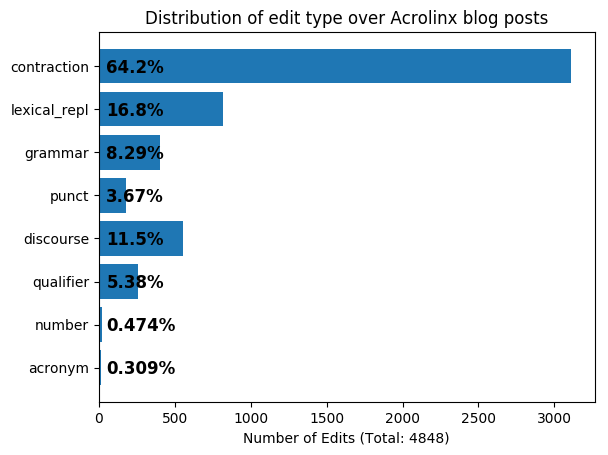

In [3]:
plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
cats = ('contraction', 'lexical_repl', 'grammar', 'punct', 'discourse', 'qualifier', 'number', 'acronym')
y_pos = np.arange(len(cats))
vals = np.array([sum(edit_df[item]*edit_df['count']) for item in cats])

ax.barh(y_pos, vals, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(cats)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Number of Edits (Total: ' + str(sum(edit_df['count'])) + ')')
ax.set_title('Distribution of edit type over Acrolinx blog posts')

for i, v in enumerate(vals):
    perc = '%s' % float('%0.3g' % (v / sum(edit_df['count']) * 100))
    ax.text(50, i + .15, str(perc) + '%', color='black', fontweight='bold', fontsize='large')
    
plt.savefig('data/Acrolinx Blog Posts/distr_fig')
plt.show()

In [14]:
edit_df.to_pickle('data/Acrolinx Blog Posts/organized_edits.pkl')

# get lists of discourse & qualifiers

In [7]:
disc = list(edit_df[edit_df['qualifier'] == True]['original'])

In [8]:
disc

['how just how',
 'Look Just look',
 'is actually is',
 'often often just',
 'At Acrolinx Here at Acrolinx',
 'Please ask Ask',
 'same exact same',
 'what just what',
 ', , then',
 'hundreds literally hundreds',
 "we will we 'll just",
 'easier a lot easier',
 'are are , of course ,',
 "You have You 've really got",
 'say just say',
 'may might just',
 'it is probably take',
 'Well , my Well , sort of ... My',
 'been simply been',
 'the opposite the exact opposite',
 'This is an important piece This is an incredibly important piece',
 'free time some free time',
 'give usually give',
 'may may well',
 'three seconds all of three seconds',
 'millennial millennial ( or anyone )',
 'how few just how few',
 'is is just',
 'obvious blatantly obvious',
 'in the comments section . in the comments section below !',
 'soon soon ... er… presently',
 'Everyone Quite simply , everyone',
 'it will be easier it will be much easier',
 'or break or even occasionally break',
 'fine also fine',
 'At Her